# Import supporting package

In [1]:
import xarray as xr
import numpy as np
import copy

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath
import random
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import NewFitModel, DensityProfileBEC2dModel
from ToolFunction.ToolFunction import *

from scipy.optimize import curve_fit

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

import Analyser.FitAnalyser as fa
# %matplotlib notebook

## Start a client for parallel computing

dict_keys(['camera_3'])
The detected scaning axes and values are: 

{}


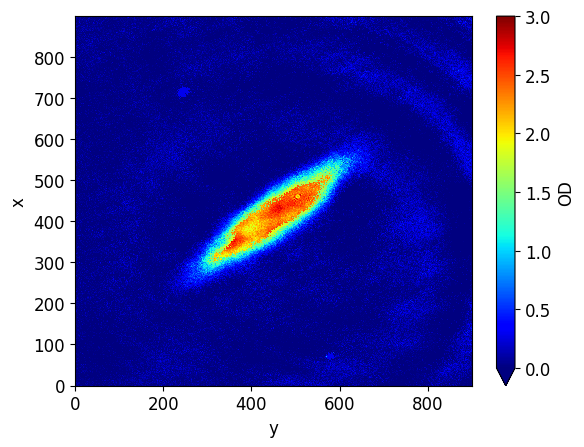

In [2]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
    "images/Vertical_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
    "images/Vertical_Axis_Camera/in_situ_absorption": "camera_3"
}

img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/08/30'# get_date()

shotNum = f"0077"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [3]
}
print(dataSetDict.keys())

dataSet = dataSetDict["camera_3"]


print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (550, 750)
imageAnalyser.span = (900, 900)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', col=scanAxis[0], row=scanAxis[1], vmin=0, vmax=3)


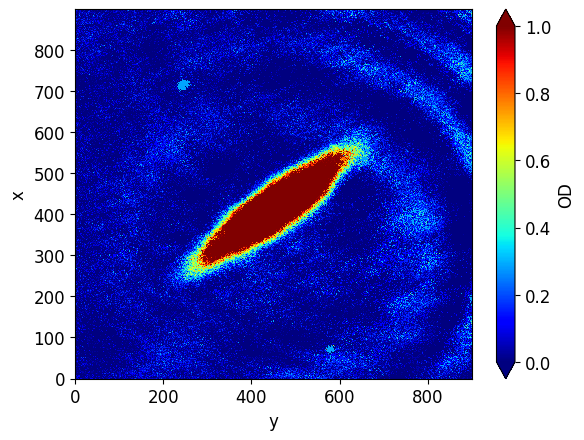

In [3]:
dataSet_cropOD.plot.pcolormesh(cmap='jet', col=scanAxis[0], row=scanAxis[1], vmin=0, vmax=1)

In [4]:
from scipy.ndimage import rotate

In [5]:
data_rot = copy.deepcopy(dataSet_cropOD)
data_rot.data = rotate(data_rot.data, 36, reshape=False)

In [6]:
x = dataSet_cropOD.x.data
y = dataSet_cropOD.y.data

X,Y = np.meshgrid(x,y)
X_ = X.flatten()
Y_ = Y.flatten()
# print(y)

In [25]:
params.data['x0_bec']

type: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

shape: (900, 900)


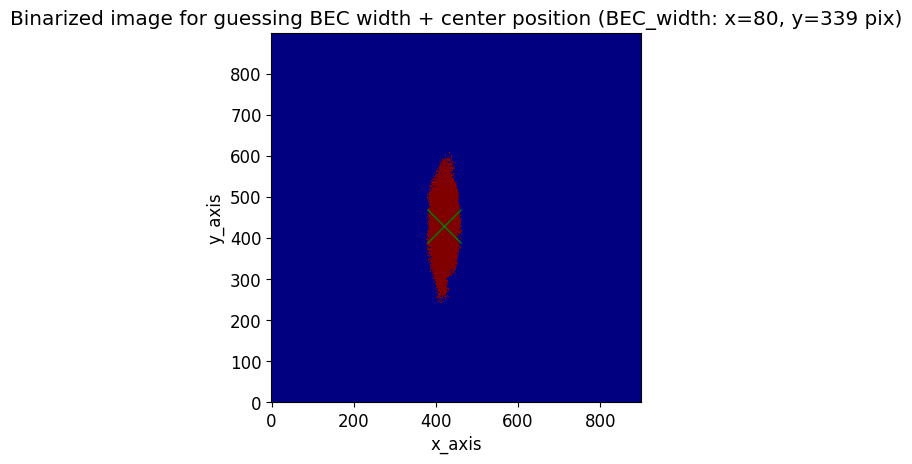

x smaller y, 1d fit along x

1d fit initialization
center = [419. 428.]
BEC widths: [ 80 339]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.145        0    2.977     None     True     None     None
amp_th        1.145        0    2.977     None     True     None     None
deltax          240        0      900     None     True     None     None
sigma_bec     65.57        0      160     None     True     None     None
sigma_th      165.8        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec          419      409      429     None     True     None     None
x0_th           419      409      429     None     True     None     None
1d fitted values
x0_bec: 421.007, (init = 419.000), bounds = [409.00 : 429.00] 
x0_th: 409.000, (init = 419.000), bounds = [409.00 : 429.00] 
amp_bec: 1.923, (init = 1.145), bounds = [0.00 : 2.98] 
amp_th: 0.351, (init = 1.145), bounds = [0.00 : 2.98] 
sigma_bec: 63.902

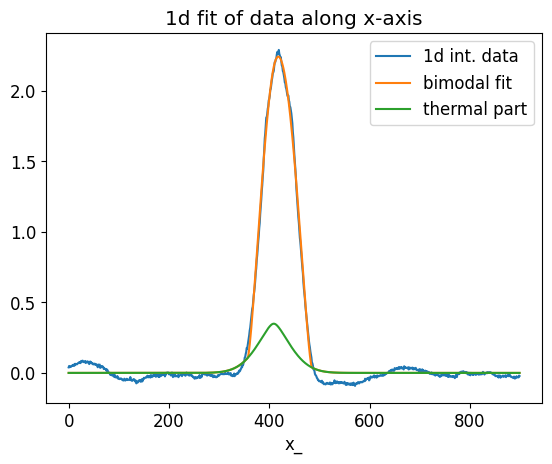


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 2.348        0    3.812     None     True     None     None
amp_th                 0.4282        0    3.812     None     True     None     None
atom_number_bec      5.239e+04     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th           3211     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.9423     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                40.39        0      900     None     True     None     None
sigmax_bec               63.9        0      160     None     True     None     None
sigmay_bec              277.9        0      678     None     True     None   

In [13]:
data =  dataSet_cropOD
fitModel = DensityProfileBEC2dModel(is_debug=True)
fitAnalyser_1 = FitAnalyser(fitModel, fitDim=2)
params = fitAnalyser_1.guess(data, guess_kwargs=dict(rot_angle=36, vary_rot=False, pre_check=False, post_check=False))
result = fitAnalyser_1.fit(data, paramsArray=params)
# result = fitModel.fit(data.data.flatten('F'), x= X_, y=Y_)


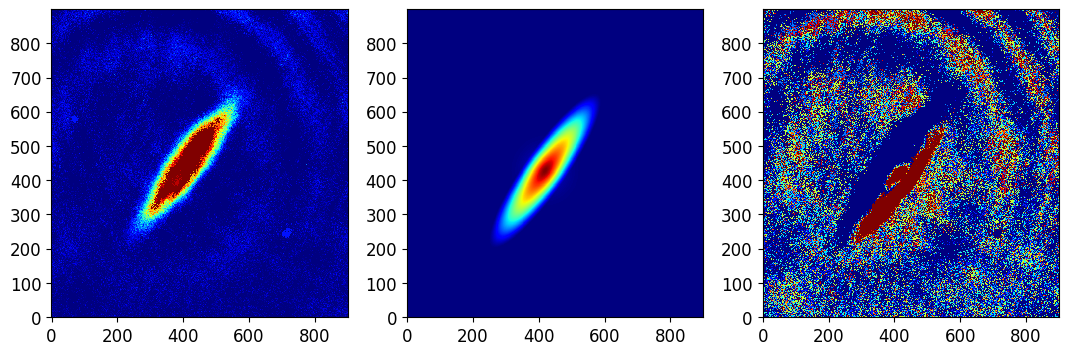

In [12]:
# fig, axs = plt.subplots(shape[0] , 5, figsize=(14, 4 * shape[0] ),dpi = 100)
fig, axs = plt.subplots(1 , 3, figsize=(13,4  ),dpi = 100)

vmax=2
cropOD = data.to_numpy()


# axs[i,0].set_title(f'image {i}, cond. frac = {Fitmodel.cond_frac(result[i], X, Y) *1e2:.2f} %', loc='left', fontsize=18)
man_fit = fa.density_profile_BEC_2d(X,Y, amp_bec=2.348, amp_th=0.4282, sigma_th=40.39, sigmax_bec=64, sigmay_bec=278, 
                                x0_bec=419,x0_th=419,y0_bec=428, y0_th=428, rot_angle=-36)


ax = axs[0]
ax.pcolormesh(X, Y, cropOD.T, vmin=0, vmax=vmax, cmap='jet', shading='auto')
#plt.colorbar(art, ax=ax, label='z')


# Plot gaussian 2d Fit + legend including Width parameters
ax = axs[1]

ax.pcolormesh(X, Y, man_fit, cmap='jet', shading='auto')
#plt.colorbar(art, ax=ax, label='z')

ax = axs[2]

ax.pcolormesh(X, Y, man_fit-cropOD.T, vmin=0, vmax=0.2, cmap='jet', shading='auto')


In [ ]:
import Analyser.FitAnalyser as fa
import numpy as np
for angle in np.arange(0,180,30):
    print()
    print(angle)
    print(fa.density_profile_BEC_2d(0.5,0.2, rot_angle=angle))


0
0.5
0.2
0.5
0.2
1.3375883632180532

30
0.5
0.2
0.5330127018922194
-0.07679491924311221
1.3375883632180532

60
0.5
0.2
0.4232050807568878
-0.33301270189221926
1.3375883632180534

90
0.5
0.2
0.20000000000000004
-0.5
1.3375883632180532

120
0.5
0.2
-0.07679491924311213
-0.5330127018922193
1.3375883632180536

150
0.5
0.2
-0.3330127018922194
-0.42320508075688773
1.3375883632180532


In [ ]:
x = dataSet_cropOD.x.data
y = dataSet_cropOD.y.data

X,Y = np.meshgrid(x,y)
X_ = X.flatten()
Y_ = Y.flatten()

In [15]:
keys = ['amp_bec', 'amp_th','x0_bec','y0_bec','x0_th','y0_th','sigmax_bec','sigmay_bec','sigma_th','rot_angle']

In [16]:
res = fitAnalyser_1.get_fit_value(result)
bval = {}
for key in keys:
    bval[key] = float(res[key].data)
print(bval)

{'amp_bec': 2.63233857911176, 'amp_th': 2.2068623923891248e-06, 'x0_bec': 409.00000000030843, 'y0_bec': 437.9999999999945, 'x0_th': 409.00151243134604, 'y0_th': 437.99999780448076, 'sigmax_bec': 69.91365732143392, 'sigmay_bec': 283.51382854536473, 'sigma_th': 65.90653264163306, 'rot_angle': -36.0}


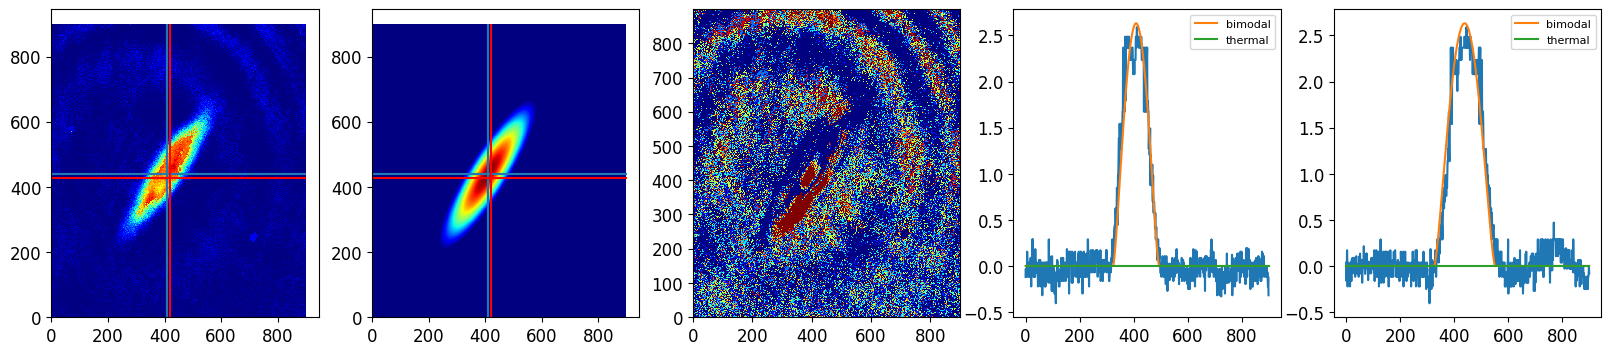

In [29]:
# fig, axs = plt.subplots(shape[0] , 5, figsize=(14, 4 * shape[0] ),dpi = 100)
shape = [1]
fig, axs = plt.subplots(shape[0] , 5, figsize=(20,4 * shape[0] ),dpi = 100)
# fig.suptitle(f'{file}_{saveprefix}: ν = ({data_x.trap_f[0]}, {data_x.trap_f[1]}, {data_x.trap_f[2]}) Hz, T = {data_x.temp[0]*1e9:.0f}nK, tof = {data_x.tof * 1e3:.0f}ms, a = {data_x.a_fac :.0f}a$_0$, N = {data_x.N:.0e} ', y=-0.005*shape[0]+0.965, fontsize=24)
# fig.suptitle('test', va='bottom')
cropOD = data.to_numpy()
for i in range(0,shape[0]):

    # axs[i,0].set_title(f'image {i}, cond. frac = {Fitmodel.cond_frac(result[i], X, Y) *1e2:.2f} %', loc='left', fontsize=18)
    man_fit = fa.density_profile_BEC_2d(X,Y, amp_bec=2.348, amp_th=0.4282, sigma_th=40.39, sigmax_bec=64, sigmay_bec=278, 
                                    x0_bec=419,x0_th=419,y0_bec=428, y0_th=428, rot_angle=-36)
    
    # bval = result.best_values
    fit = fa.density_profile_BEC_2d(X,Y, **bval)
    vmax = np.max(cropOD)
    # vmax = 1

    if bval['amp_bec'] > bval['amp_th']:
        cen_str = 'bec'
    else:
        cen_str = 'th'
    cen_x = round(bval[f'x0_{cen_str}'])
    cen_y = round(bval[f'y0_{cen_str}'])

    ax = axs[0]
    ax.pcolormesh(X, Y, cropOD.T, vmin=0, vmax=vmax, cmap='jet', shading='auto')
    #plt.colorbar(art, ax=ax, label='z')


    # Plot gaussian 2d Fit + legend including Width parameters
    ax = axs[1]

    ax.pcolormesh(X, Y, fit, cmap='jet', shading='auto')
    #plt.colorbar(art, ax=ax, label='z')

    ax = axs[2]

    ax.pcolormesh(X, Y, fit-cropOD.T, vmin=0, vmax=0.2, cmap='jet', shading='auto')

    for i in range(0,2):
        axs[i].hlines(bval['y0_bec'], 0,900)
        axs[i].hlines(bval['y0_th'], 0,900)

        axs[i].vlines(bval['x0_bec'], 0,900)
        axs[i].vlines(bval['x0_th'], 0,900)

        axs[i].vlines(419, 0,900, color='red')
        axs[i].hlines(428, 0,900, color='red')

    ax = axs[3]

    ax.plot(x, cropOD.T[cen_y, :])
    ax.plot(x, fit[cen_y, :], label='bimodal')
    ax.plot(x, fa.thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']), label='thermal')
    ax.legend(fontsize=8)

    ax = axs[4]

    ax.plot(y, cropOD.T[:, cen_x])
    ax.plot(y, fit[:, cen_x], label='bimodal')
    ax.plot(y, fa.thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']), label='thermal')
    ax.legend(fontsize=8)


t_fonts=20


In [28]:
fit[300, 400]

2.527851655733842e-109

In [27]:
X

array([[  0,   1,   2, ..., 897, 898, 899],
       [  0,   1,   2, ..., 897, 898, 899],
       [  0,   1,   2, ..., 897, 898, 899],
       ...,
       [  0,   1,   2, ..., 897, 898, 899],
       [  0,   1,   2, ..., 897, 898, 899],
       [  0,   1,   2, ..., 897, 898, 899]], dtype=int64)

In [ ]:
%matplotlib notebook
shotNum = "0024"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i], excludeAxis = ['sweep_start_freq', 'sweep_stop_freq'])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (135, 990)
imageAnalyser.span = (250, 250)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)

fig = plt.figure()
ax = fig.gca()
Ncount_mean.plot.errorbar(ax=ax, yerr = Ncount_std, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
#plt.ylim([0, 3500])
plt.grid(visible=1)
plt.show()

In [ ]:
l = list(np.arange(0.15, 0.25, 0.005))
# l = np.logspace(np.log10(250e-6), np.log10(500e-3), num=15)

l = [round(item, 7) for item in l]
random.shuffle(l)

print(l)
print(len(l))
np.mean(l)

In [ ]:
[10.25, 10.255, 10.26, 10.265, 10.27, 10.275, 10.28, 10.285, 10.29, 10.295, 10.3, 10.305, 10.31, 10.315, 10.32, 10.325, 10.33, 10.335, 10.34, 10.345, 10.35, 10.355]

In [ ]:
pixel = 5.86e-6
M     = 0.6827
F = (1/(0.3725*8.4743e-14)) * (pixel / M)**2
NCount = 85000
AtomNumber = NCount * F / 1e8
print(AtomNumber)


In [ ]:
muB = 9.274e-24
hbar = 6.626e-34 / (2 * np.pi)
gJ = 1.24
Delta = 2 * np.pi * 100 * 1e3

Bz = (Delta*hbar) / (muB*gJ)
print(Bz * 1e4)

## ODT 1 Calibration

In [ ]:
v_high = 2.7
"""High Power"""
P_arm1_high = 5.776 * v_high - 0.683

v_mid = 0.2076
"""Intermediate Power"""
P_arm1_mid = 5.815 * v_mid - 0.03651

v_low = 0.0587
"""Low Power"""
P_arm1_low = 5271 * v_low - 27.5

print(round(P_arm1_high, 3))
print(round(P_arm1_mid, 3))
print(round(P_arm1_low, 3))

## ODT 2 Power Calibration

In [ ]:
v = 0.7607
P_arm2 = 2.302 * v - 0.06452
print(round(P_arm2, 3))